# Analysis of Daily Sports and Activities using Motion Sensors

### Summary

<p> The aim of this notebook is to analyze the sensor data from the Daily Sports and Activities Dataset provided at UCI machine learning repo, and build a robust Activity classifier based on it.</p>
<p> <b>Dataset Definition:</b><br> Each of the 19 activities is performed by eight subjects (4 female, 4 male, between the ages 20 and 30) for 5 minutes.  </p> 

<p> Total signal duration is 5 minutes for each activity of each subject.
String inter-subject variations in the speeds and amplitudes of some activities. </p> 

<p> The activities are performed at the Bilkent University Sports Hall, in the Electrical and Electronics Engineering Building, and in a flat outdoor area on campus. Sensor units are calibrated to acquire data at 25 Hz sampling frequency. The 5-min signals are divided into 5-sec segments so that 480(=60x8) signal segments are obtained for each activity. </p> 

<p> The 19 activities are:<br>
sitting (A1),<br>
standing (A2),<br>
lying on back and on right side (A3 and A4),<br>
ascending and descending stairs (A5 and A6),<br>
standing in an elevator still (A7)<br>
and moving around in an elevator (A8),<br>
walking in a parking lot (A9),<br>
walking on a treadmill with a speed of 4 km/h (in flat and 15 deg inclined positions) (A1
0 and A11),<br>
running on a treadmill with a speed of 8 km/h (A12),<br>
exercising on a stepper (A13),<br>
exercising on a cross trainer (A14),<br>
cycling on an exercise bike in horizontal and vertical positions (A15 and A16),
rowing (A17),<br>
jumping (A18),<br>
and playing basketball (A19). </p> 

<p> <b>For convenience, we're shifting the identifying number of each activity and person down by one such that activity-1 is represented by 0 and so on.</b> </p> 


The following modules and libraries are used for this notebook, the need for each of which is defined in the comments:

In [2]:
#for monitoring training time and performance of various models while hyperparameter tuning
import time

#transformation and statistical operations
import numpy as np
import scipy.stats as ss
from scipy import fft

#for importing datasets
import os
import sklearn.datasets
from sklearn import decomposition

#ML and Metrics
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB

#DL
import keras
from keras.models import Sequential
from keras.layers import LSTM,GRU,Dense,Activation,Dropout

#visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

### Importing the Dataset
<p> File structure tree definition:<br>

folder: 19 activities (a) (in the order given above)<br>
subfolder: 8 subjects (p)<br>
Textfiles: 60 segments(5secs each, sampled @25khz) (s)<br>
Within Textfiles:<br>
5 units on torso (T), right arm (RA), left arm (LA), right leg (RL), left leg (LL)<br>
9 sensors on each unit (x,y,z accelerometers, x,y,z gyroscopes, x,y,z magnetometers)<br>
 </p> 

<p>importing the dataset was a bit tricky because of the raw file format and structure. the import was performed using nested loops and scikit-learn's  datasert library</p>
 <p>The data is parsed and arranged in a multi dimensional numpy array, indexed as:<br>
 [activity 0-18][persons 0-7][segments 0-59][samples 0-124][sensor readings 0-44]</p>

In [3]:
data = [a for a in range(19)]
#starting indices from zero for convenience
#output = data = [activity 0-18][persons 0-7][segments 0-59][n 0-124]
#series[]
for a in range(19):
    zr = "0" if a+1<10 else ""
    x = sklearn.datasets.load_files("sensor_dataset/a"+zr+str(a+1),shuffle=False,load_content=True,encoding="utf-8")
    inc = 0
    data[a] = [p for p in range(8)]
    for p in range(8):
        data[a][p] = [x.data[n].splitlines() for n in range(inc,inc+60)];
        inc+=60
        for s in range(60):
            for n in range(125):
                data[a][p][s][n] = np.array([v for v in data[a][p][s][n].split(',')]).astype(np.float32)

data_set = np.array(data)
print(data_set.shape)

(19, 8, 60, 125, 45)


The next two operations involve further decomposing the dataset to define sensor outputs from unique units, and subsampling the time series to get 5 x 60 second feature vectors

In [4]:
#5 units x 9 sensor outputs
per_sensor = np.reshape(data_set,[19, 8, 60*125,5,9])
#uniform subsampling of 7500 samples@25hz to 5x60sec 
X = per_sensor[:,:,::25]
X.shape

(19, 8, 300, 5, 9)

### Data Exploration

We can quickly get a rough idea of the various activities' sensor data by plotting the means of different units(torso, left arm, right arm, left leg, right leg) in a time series. we make the following observations:<br>
* We notice that semi static activities such as standing and sitting have very miniscule spreads as compared to more complex activities.
* Some activities like jumping and running seem to have somewhat periodic fluctuations
* Other activities such as basketball are extremely random and should pose a major threat to proper classification
* We also notice that certain activities are performed almost similarly by all subjects while some activities are performed very differently by the different subjects.
<br>Feel free to plot and compare the various activities and subject relations by modifying the following snippet.
<br>eg plt.plot(x_mean[6,0,:,:] plots the data of the 7th\* activity performed by the 1st\* subject
<br>*(because indexes start from 0)

(19, 8, 300, 5)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


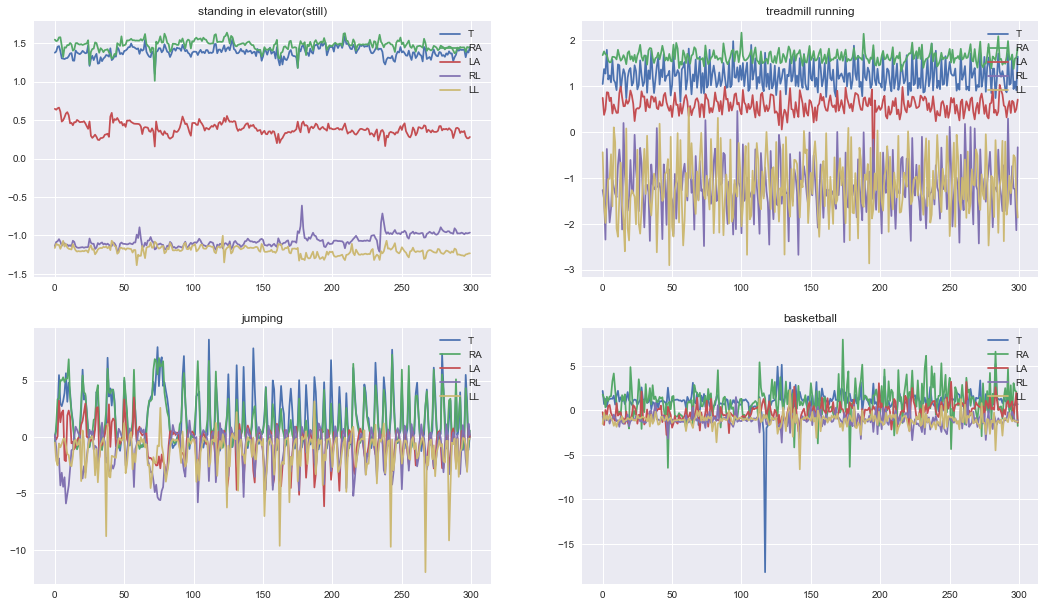

In [7]:
#plotting some sensor data
x_mean = X.mean(axis=4)
print(x_mean.shape)
plt.figure(figsize=[18,16])
plt.subplot(321)
plt.plot(x_mean[6,0,:,:])
plt.title("standing in elevator(still)")
plt.legend(["T","RA","LA","RL","LL"], loc=1)
plt.subplot(322)
plt.plot(x_mean[9,0,:,:])
plt.legend(["T","RA","LA","RL","LL"], loc=1)
plt.title("treadmill running")
plt.legend()
plt.subplot(323)
plt.plot(x_mean[17,0,:,:])
plt.legend(["T","RA","LA","RL","LL"], loc=1)
plt.title("jumping")
plt.legend()
plt.subplot(324)
plt.plot(x_mean[18,0,:,:])
plt.legend(["T","RA","LA","RL","LL"], loc=1)
plt.title("basketball")
plt.legend()

#### Custom Feature extraction
Along with the mean values, we are generating 6 more feature vectors based on the following operations:
* minimum and maximum
* skewness
* variance
* kurtosis

In [8]:
x_variance = X.var(axis=4)
x_skew = ss.skew(X,axis=4)
x_kurt = ss.kurtosis(X,axis=4)
x_min = X.min(axis=4)
x_max = X.max(axis=4)

print(x_variance.shape)
print(x_skew.shape)
print(x_kurt.shape)
print(x_min.shape)
print(x_max.shape)

(19, 8, 300, 5)
(19, 8, 300, 5)
(19, 8, 300, 5)
(19, 8, 300, 5)
(19, 8, 300, 5)


#### Plotting the custom features

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


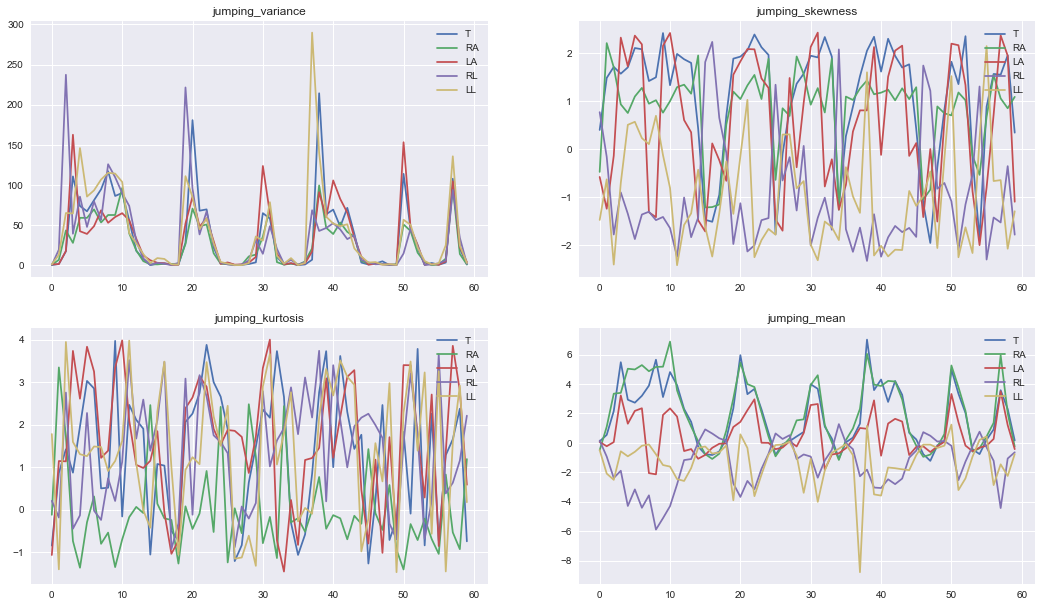

In [9]:
#60 seconds
plt.figure(figsize=[18,16])
plt.subplot(321)
plt.plot(x_variance[17,0,:60])
plt.title("jumping_variance")
plt.legend(["T","RA","LA","RL","LL"], loc=1)
plt.subplot(322)
plt.plot(x_skew[17,0,:60])
plt.legend(["T","RA","LA","RL","LL"], loc=1)
plt.title("jumping_skewness")
plt.legend()
plt.subplot(323)
plt.plot(x_kurt[17,0,:60])
plt.legend(["T","RA","LA","RL","LL"], loc=1)
plt.title("jumping_kurtosis")
plt.legend()
plt.subplot(324)
plt.plot(x_mean[17,0,:60])
plt.legend(["T","RA","LA","RL","LL"], loc=1)
plt.title("jumping_mean")
plt.legend()

### Generating Feature Vectors

We are devising 4 variations of the Feature vectors which are as follows:
* flattened_x: raw sensor data(5 units x 3 sensors x 3 axis readings) of the shape (19, 8, 300, 45)
* custom_feature_vecs: Concatenated Custom features from our previous custom feature extraction(5 units x 6 operations) (19, 8, 300, 30)
* hybrid_vec: A combination of flattened_x and custom features (19, 8, 300, 75)
* small_x: small version of flattened_x with 5 activities only for performance testing purposes (5, 8, 300, 45)

In [10]:
flattened_x = np.reshape(X,[19,8,300,5*9])
custom_feature_vecs = np.concatenate([x_min,x_max,x_mean,x_variance,x_skew,x_kurt],axis=3)
hybrid_vec = np.concatenate([flattened_x,x_min,x_max,x_mean,x_variance,x_skew,x_kurt],axis=3)
print(flattened_x.shape)
print(custom_feature_vecs.shape)
print(hybrid_vec.shape)
#first 5 activities only
small_x = flattened_x[:5]
print(small_x.shape)

(19, 8, 300, 45)
(19, 8, 300, 30)
(19, 8, 300, 75)
(5, 8, 300, 45)


### Splitting Training and Test Data

The data is assorted in such a way that for each activity is performed such that the first 4 subjects are male and the next 4 are female. A general conjecture can suggest that while each activity's sensor data might have strong similaries accross all subjects, there should a strong variance between the male and female subjects. So if we need to split the subjects for testing data, the best way to do so should be to extract one subject from each sex and use the remaining 6 subjects for training data. This might initially reduce the test accuracy but will result in more accurate global results.

In [13]:
#raw feature splits
train_x_m = np.split(flattened_x,[3,8],axis=1)[0]
train_x_f = np.split(flattened_x,[4,7,8],axis=1)[1]
test_x_m = np.split(flattened_x,[3,4,8],axis=1)[1]
test_x_f = np.split(flattened_x,[7,8],axis=1)[1]
train_x = np.reshape(np.concatenate((train_x_m,train_x_f),axis=1),[19*6,300,45])
test_x = np.reshape(np.concatenate((test_x_m,test_x_f),axis=1),[19*2,300,45])
train_y = np.expand_dims(np.repeat([i for i in range(19)],6),axis=1)
test_y = np.expand_dims(np.repeat([i for i in range(19)],2),axis=1)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(114, 300, 45) (114, 1) (38, 300, 45) (38, 1)


In [14]:
#small splitset for testing purposes
train_small_x_m = np.split(small_x,[3,8],axis=1)[0]
train_small_x_f = np.split(small_x,[4,7,8],axis=1)[1]
test_small_x_m = np.split(small_x,[3,4,8],axis=1)[1]
test_small_x_f = np.split(small_x,[7,8],axis=1)[1]
train_small_x = np.reshape(np.concatenate((train_small_x_m,train_small_x_f),axis=1),[5*6,300,45])
test_small_x = np.reshape(np.concatenate((test_small_x_m,test_small_x_f),axis=1),[5*2,300,45])
train_small_y = np.expand_dims(np.repeat([i for i in range(5)],6),axis=1)
test_small_y = np.expand_dims(np.repeat([i for i in range(5)],2),axis=1)
print(train_small_x.shape, train_small_y.shape, test_small_x.shape, test_small_y.shape)

(30, 300, 45) (30, 1) (10, 300, 45) (10, 1)


In [15]:
#custom feature splits
#pulling activity value one down to match indices
train_x_m = np.split(custom_feature_vecs,[3,8],axis=1)[0]
train_x_f = np.split(custom_feature_vecs,[4,7,8],axis=1)[1]
test_x_m = np.split(custom_feature_vecs,[3,4,8],axis=1)[1]
test_x_f = np.split(custom_feature_vecs,[7,8],axis=1)[1]
ctrain_x = np.reshape(np.concatenate((train_x_m,train_x_f),axis=1),[19*6,300,30])
ctest_x = np.reshape(np.concatenate((test_x_m,test_x_f),axis=1),[19*2,300,30])
ctrain_y = np.expand_dims(np.repeat([i for i in range(19)],6),axis=1)
ctest_y = np.expand_dims(np.repeat([i for i in range(19)],2),axis=1)
print(ctrain_x.shape, ctrain_y.shape, ctest_x.shape, ctest_y.shape)

(114, 300, 30) (114, 1) (38, 300, 30) (38, 1)


In [16]:
#hybrid feature splits
#pulling activity value one down to match indices
train_x_m = np.split(hybrid_vec,[3,8],axis=1)[0]
train_x_f = np.split(hybrid_vec,[4,7,8],axis=1)[1]
test_x_m = np.split(hybrid_vec,[3,4,8],axis=1)[1]
test_x_f = np.split(hybrid_vec,[7,8],axis=1)[1]
htrain_x = np.reshape(np.concatenate((train_x_m,train_x_f),axis=1),[19*6,300,30+45])
htest_x = np.reshape(np.concatenate((test_x_m,test_x_f),axis=1),[19*2,300,30+45])
htrain_y = np.expand_dims(np.repeat([i for i in range(19)],6),axis=1)
htest_y = np.expand_dims(np.repeat([i for i in range(19)],2),axis=1)
print(htrain_x.shape, htrain_y.shape, htest_x.shape, htest_y.shape)

(114, 300, 75) (114, 1) (38, 300, 75) (38, 1)


### Classification Models
Once past we've got our training and test sets ready, we can start implementing various classification models to the dataset. While building the learning models we first use each of our previously generated training and test pairs. Especially in the case of neural networks, we first try out the small test set to get an approximation of the model complexity and training time. After some experiments it was realized the hybrid training-test pair resulted in the best accuracy results without having any major impact on the training times.

#### Bernoulli Naive Bayes
The Bernoulli Naive Bayes model was the first to give us near accurate results, with a training accuracy of 99% and an accuracy of 76.3% on the test set.
After Assessing the basic metrics, we plot a confusion matrix to get an idea of which activities were misclassified and also notice the relations between the pairs of activities which were confused with each other.

Training Accuracy: 0.991228070175
Test Accuracy: 0.763157894737


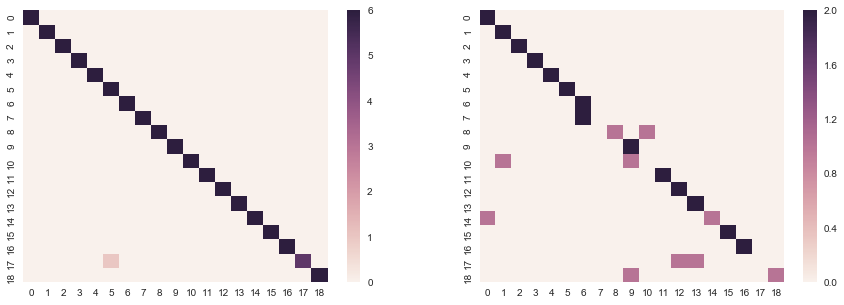

In [32]:
# fit a Naive Bayes bmodel to the data
bmodel = BernoulliNB()
bmodel.fit(htrain_x.reshape([114, 300*75]), htrain_y.reshape(htrain_y.shape[0],))
#print(bmodel)

# make predictions
expected = htrain_y.reshape(htrain_y.shape[0],)
predicted = bmodel.predict(htrain_x.reshape([114, 300*75]))
# summarize the fit of the bmodel
print("Training Accuracy:",metrics.accuracy_score(expected, predicted))
#print(metrics.confusion_matrix(expected, predicted))
plt.figure(figsize=[15,5])
plt.subplot(121)
sn.heatmap(metrics.confusion_matrix(expected, predicted))

expected = htest_y.reshape(htest_y.shape[0],)
predicted = bmodel.predict(htest_x.reshape([38, 300*75]))
# summarize the fit of the bmodel
print("Test Accuracy:",metrics.accuracy_score(expected, predicted))
#print(metrics.confusion_matrix(expected, predicted))
plt.subplot(122)
sn.heatmap(metrics.confusion_matrix(expected, predicted))

### Recurrent Neural Networks

The first intuition was to test out the different variants of reccurent neural networks on our dataset due to the sequence learning nature of the same.<br>
The initial tests involved the use of LSTM layers which, while more accurate than traditional RNN layers which suffered from vanishing/exploding gradient issues, were rather time consuming on our larger training sets.<br>
The solution was to replace the LSTM layers with Gated Recurrent Units with proved to be just as accurate along with a significantly shorter training time, this was because of the simpler mechanism of GRU based layers.<br>
Adding dropout layers also helped in significantly reducing the training time.<br>
After a long while of hyperparameter tuning, we finally defined the following structure to be the most effecient option for our Sequential neural networks:
* LSTM/GRU Layer: 128 neurons, returns sequences.
* Dropout Layer: 40%
* LSTM/GRU Layer: 64 neurons
* Dropout Layer: 20%
* Logits/Dense/Fully Connected layer: 19 neurons
* Softmax Activation Layer - Output
<br>
We used the loss function: sparse categorical cross-entropy, which is slightly different from traditional categorical cross entropy as it does not need one hot coded label data.
<br>
We tested 3 optimizers with our model which included SGD, Adam, and RMSProp. While SGD's performance wasn't up to the mark, rmsprop and adam were provided close results. Adam proved to be the best optimizer for this problem, with short epoch processing time, fast descent and a top 3 accuracy close to 97% within 128 epochs @ 64 batch size.
<br>
We also noticed that adding activation layers(relu/sigmoid) after the lstm/gru layers results in decreased accuracy.

#### Defining the top 3 accuracy metric

In [35]:
import functools
top3_acc = functools.partial(keras.metrics.sparse_top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

#### Standard Gradient Descent:
The first experiment involved the use of sgd optimizer which resulted in the following final metrics:
<br><br>Training Loss: 0.775403763119
<br>Training Accuracy: 94.7368421053 %
<br>Training Top 3 Accuracy: 100.0 %
<br>Test loss: 1.37674241631
<br>Test accuracy: 63.1578947368 %
<br>Training Top 3 Accuracy: 84.2105263158 %
<br>Approximate training time: 9 minutes

In [20]:
model_test = Sequential()
model_test.add(GRU(128, input_shape=(htrain_x.shape[1], htrain_x.shape[2]),return_sequences=True))
model_test.add(Dropout(0.4))
model_test.add(GRU(64, input_shape=(htrain_x.shape[1], htrain_x.shape[2])))
model_test.add(Dropout(0.2))
model_test.add(Dense(19))
model_test.add(Activation('softmax'))
model_test.compile(loss='sparse_categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy', top3_acc])

history_test_sgd = model_test.fit(htrain_x, htrain_y, epochs=128, batch_size=64, validation_data=(htest_x, htest_y), verbose=2, shuffle=True)

Train on 114 samples, validate on 38 samples
Epoch 1/128
7s - loss: 2.9938 - acc: 0.0614 - top3_acc: 0.2456 - val_loss: 3.1006 - val_acc: 0.0263 - val_top3_acc: 0.1579
Epoch 2/128
4s - loss: 2.9566 - acc: 0.0789 - top3_acc: 0.2105 - val_loss: 3.0302 - val_acc: 0.0526 - val_top3_acc: 0.1579
Epoch 3/128
4s - loss: 2.9510 - acc: 0.0614 - top3_acc: 0.1842 - val_loss: 2.9474 - val_acc: 0.0526 - val_top3_acc: 0.2105
Epoch 4/128
4s - loss: 2.8638 - acc: 0.0263 - top3_acc: 0.2544 - val_loss: 2.8779 - val_acc: 0.0526 - val_top3_acc: 0.2895
Epoch 5/128
4s - loss: 2.8159 - acc: 0.0789 - top3_acc: 0.2632 - val_loss: 2.8113 - val_acc: 0.1842 - val_top3_acc: 0.3158
Epoch 6/128
4s - loss: 2.6992 - acc: 0.1667 - top3_acc: 0.3947 - val_loss: 2.7670 - val_acc: 0.2105 - val_top3_acc: 0.3684
Epoch 7/128
4s - loss: 2.6290 - acc: 0.1754 - top3_acc: 0.4298 - val_loss: 2.7351 - val_acc: 0.1842 - val_top3_acc: 0.4474
Epoch 8/128
4s - loss: 2.6842 - acc: 0.1316 - top3_acc: 0.3860 - val_loss: 2.6840 - val_acc: 0

4s - loss: 1.4255 - acc: 0.7193 - top3_acc: 0.9211 - val_loss: 1.7260 - val_acc: 0.5000 - val_top3_acc: 0.7895
Epoch 68/128
4s - loss: 1.4324 - acc: 0.6667 - top3_acc: 0.9035 - val_loss: 1.7129 - val_acc: 0.5000 - val_top3_acc: 0.7895
Epoch 69/128
4s - loss: 1.4506 - acc: 0.6754 - top3_acc: 0.9123 - val_loss: 1.7111 - val_acc: 0.5263 - val_top3_acc: 0.7895
Epoch 70/128
4s - loss: 1.4688 - acc: 0.6404 - top3_acc: 0.8947 - val_loss: 1.7075 - val_acc: 0.5263 - val_top3_acc: 0.8158
Epoch 71/128
4s - loss: 1.3987 - acc: 0.7719 - top3_acc: 0.9298 - val_loss: 1.6985 - val_acc: 0.5000 - val_top3_acc: 0.8421
Epoch 72/128
4s - loss: 1.3851 - acc: 0.6667 - top3_acc: 0.9298 - val_loss: 1.6928 - val_acc: 0.5000 - val_top3_acc: 0.8421
Epoch 73/128
4s - loss: 1.3898 - acc: 0.7193 - top3_acc: 0.9123 - val_loss: 1.6778 - val_acc: 0.5000 - val_top3_acc: 0.7895
Epoch 74/128
4s - loss: 1.4013 - acc: 0.7193 - top3_acc: 0.9561 - val_loss: 1.6704 - val_acc: 0.5000 - val_top3_acc: 0.8158
Epoch 75/128
4s - los

In [21]:
scores = model_test.evaluate(htrain_x, htrain_y, verbose=1)
print('Training Loss:', scores[0])
print('Training Accuracy:', scores[1]*100,'%')
print('Training Top 3 Accuracy:', scores[2]*100,'%')
scores = model_test.evaluate(htest_x, htest_y, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1]*100,'%')
print('Training Top 3 Accuracy:', scores[2]*100,'%')

114/114 [==============================] - 1s     
Training Loss: 0.775403763119
Training Accuracy: 94.7368421053 %
Training Top 3 Accuracy: 100.0 %
38/38 [==============================] - 0s     
Test loss: 1.37674241631
Test accuracy: 63.1578947368 %
Training Top 3 Accuracy: 84.2105263158 %


#### RMSPROP
Using the rmsprop optimizer resulted in a better performance with the following metrics:
<br><br>Training Loss: 0.139823080776
<br>Training Accuracy: 96.4912280702 %
<br>Training Top 3 Accuracy: 100.0 %
<br>Test loss: 1.49589552377
<br>Test accuracy: 65.7894736842 %
<br>Training Top 3 Accuracy: 92.1052631579 %
<br>Approximate Training Time: 9 minutes

In [26]:
model_test = Sequential()
model_test.add(GRU(128, input_shape=(htrain_x.shape[1], htrain_x.shape[2]),return_sequences=True,activation='relu'))
model_test.add(Dropout(0.4))
model_test.add(GRU(64, input_shape=(htrain_x.shape[1], htrain_x.shape[2]),activation='relu'))
model_test.add(Dropout(0.2))
model_test.add(Dense(19))
model_test.add(Activation('softmax'))
model_test.compile(loss='sparse_categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', top3_acc])

In [27]:
history_test_rms = model_test.fit(htrain_x, htrain_y, epochs=128, batch_size=64, validation_data=(htest_x, htest_y), verbose=2, shuffle=True)

Train on 114 samples, validate on 38 samples
Epoch 1/128
6s - loss: 5.3713 - acc: 0.0351 - top3_acc: 0.1404 - val_loss: 3.0464 - val_acc: 0.1053 - val_top3_acc: 0.1842
Epoch 2/128
4s - loss: 3.8394 - acc: 0.0789 - top3_acc: 0.2544 - val_loss: 2.8678 - val_acc: 0.0789 - val_top3_acc: 0.2368
Epoch 3/128
4s - loss: 3.5577 - acc: 0.0789 - top3_acc: 0.2193 - val_loss: 2.8996 - val_acc: 0.1053 - val_top3_acc: 0.3158
Epoch 4/128
4s - loss: 3.5516 - acc: 0.1579 - top3_acc: 0.3070 - val_loss: 2.8644 - val_acc: 0.1316 - val_top3_acc: 0.2895
Epoch 5/128
4s - loss: 3.3018 - acc: 0.1754 - top3_acc: 0.3684 - val_loss: 2.7232 - val_acc: 0.1842 - val_top3_acc: 0.3684
Epoch 6/128
4s - loss: 3.0779 - acc: 0.1491 - top3_acc: 0.3246 - val_loss: 2.6551 - val_acc: 0.1842 - val_top3_acc: 0.5000
Epoch 7/128
4s - loss: 2.8446 - acc: 0.1579 - top3_acc: 0.3421 - val_loss: 2.5296 - val_acc: 0.2632 - val_top3_acc: 0.5000
Epoch 8/128
4s - loss: 2.8437 - acc: 0.1930 - top3_acc: 0.3509 - val_loss: 2.4476 - val_acc: 0

4s - loss: 0.5966 - acc: 0.7719 - top3_acc: 0.9825 - val_loss: 1.1226 - val_acc: 0.6316 - val_top3_acc: 0.8421
Epoch 68/128
4s - loss: 0.5519 - acc: 0.8070 - top3_acc: 0.9649 - val_loss: 1.0496 - val_acc: 0.6579 - val_top3_acc: 0.8684
Epoch 69/128
4s - loss: 0.5464 - acc: 0.7807 - top3_acc: 0.9825 - val_loss: 1.1763 - val_acc: 0.6053 - val_top3_acc: 0.8421
Epoch 70/128
4s - loss: 0.6655 - acc: 0.7807 - top3_acc: 0.9825 - val_loss: 1.1786 - val_acc: 0.6842 - val_top3_acc: 0.8421
Epoch 71/128
4s - loss: 0.5923 - acc: 0.8421 - top3_acc: 0.9825 - val_loss: 1.1199 - val_acc: 0.6316 - val_top3_acc: 0.8947
Epoch 72/128
4s - loss: 0.6741 - acc: 0.8158 - top3_acc: 0.9561 - val_loss: 1.2106 - val_acc: 0.6579 - val_top3_acc: 0.8421
Epoch 73/128
4s - loss: 0.4892 - acc: 0.7632 - top3_acc: 0.9912 - val_loss: 1.1543 - val_acc: 0.6842 - val_top3_acc: 0.8684
Epoch 74/128
4s - loss: 0.5341 - acc: 0.8509 - top3_acc: 0.9825 - val_loss: 1.1679 - val_acc: 0.6842 - val_top3_acc: 0.8684
Epoch 75/128
4s - los

In [30]:
scores = model_test.evaluate(htrain_x, htrain_y, verbose=1)
print('Training Loss:', scores[0])
print('Training Accuracy:', scores[1]*100,'%')
print('Training Top 3 Accuracy:', scores[2]*100,'%')
scores = model_test.evaluate(htest_x, htest_y, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1]*100,'%')
print('Training Top 3 Accuracy:', scores[2]*100,'%')

114/114 [==============================] - 1s     
Training Loss: 0.139823080776
Training Accuracy: 96.4912280702 %
Training Top 3 Accuracy: 100.0 %
38/38 [==============================] - 0s     
Test loss: 1.49589552377
Test accuracy: 65.7894736842 %
Training Top 3 Accuracy: 92.1052631579 %


#### Adam
The adam optimizer returned the best results with the validation set top 3 acccuracy peaking at 97% (refer graph).
<br><br>Training Loss: 0.0058015209639
<br>Training Accuracy: 100.0 %
<br>Training Top 3 Accuracy: 100.0 %
<br>Test loss: 0.764951594566
<br>Test accuracy: 84.2105263158 %
<br>Training Top 3 Accuracy: 94.7368421053 % (peaked @ 97.3%)
<br>Approximate training time: 15 minutes

In [50]:
model = Sequential()
model.add(GRU(128, input_shape=(htrain_x.shape[1], htrain_x.shape[2]),return_sequences=True))
model.add(Dropout(0.4))
model.add(GRU(64, input_shape=(htrain_x.shape[1], htrain_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(19))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', top3_acc])

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 300, 128)          78336     
_________________________________________________________________
dropout_14 (Dropout)         (None, 300, 128)          0         
_________________________________________________________________
gru_8 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 19)                1235      
_________________________________________________________________
activation_8 (Activation)    (None, 19)                0         
Total params: 116,627
Trainable params: 116,627
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Save/Load the model weights
save = False
if(save):
    model.save_weights("hf_deep_gru_weights.h5")
    print('Saved trained model and weights')
else:
    model.load_weights("hf_deep_gru_weights.h5")

In [14]:
history = model.fit(htrain_x, htrain_y, epochs=128, batch_size=64, validation_data=(htest_x, htest_y), verbose=2, shuffle=True)

Train on 114 samples, validate on 38 samples
Epoch 1/128
6s - loss: 3.1647 - acc: 0.0526 - top3_acc: 0.1228 - val_loss: 3.0217 - val_acc: 0.0526 - val_top3_acc: 0.1579
Epoch 2/128
4s - loss: 2.8676 - acc: 0.1404 - top3_acc: 0.2632 - val_loss: 2.8070 - val_acc: 0.1842 - val_top3_acc: 0.3421
Epoch 3/128
4s - loss: 2.6692 - acc: 0.1842 - top3_acc: 0.3860 - val_loss: 2.6512 - val_acc: 0.2632 - val_top3_acc: 0.3684
Epoch 4/128
4s - loss: 2.5202 - acc: 0.2193 - top3_acc: 0.5263 - val_loss: 2.5188 - val_acc: 0.2632 - val_top3_acc: 0.4474
Epoch 5/128
4s - loss: 2.3664 - acc: 0.3158 - top3_acc: 0.6053 - val_loss: 2.4090 - val_acc: 0.3158 - val_top3_acc: 0.5000
Epoch 6/128
4s - loss: 2.2503 - acc: 0.3772 - top3_acc: 0.6667 - val_loss: 2.3063 - val_acc: 0.3684 - val_top3_acc: 0.6053
Epoch 7/128
4s - loss: 2.1400 - acc: 0.4298 - top3_acc: 0.7018 - val_loss: 2.2161 - val_acc: 0.3684 - val_top3_acc: 0.6842
Epoch 8/128
4s - loss: 1.9916 - acc: 0.6053 - top3_acc: 0.7895 - val_loss: 2.1315 - val_acc: 0

4s - loss: 0.0786 - acc: 0.9912 - top3_acc: 1.0000 - val_loss: 0.7936 - val_acc: 0.7632 - val_top3_acc: 0.9211
Epoch 68/128
4s - loss: 0.0816 - acc: 0.9912 - top3_acc: 1.0000 - val_loss: 0.6992 - val_acc: 0.8158 - val_top3_acc: 0.9211
Epoch 69/128
4s - loss: 0.0904 - acc: 0.9825 - top3_acc: 1.0000 - val_loss: 0.6604 - val_acc: 0.8684 - val_top3_acc: 0.9211
Epoch 70/128
4s - loss: 0.1142 - acc: 0.9737 - top3_acc: 1.0000 - val_loss: 0.6833 - val_acc: 0.8158 - val_top3_acc: 0.9211
Epoch 71/128
6s - loss: 0.1050 - acc: 0.9912 - top3_acc: 1.0000 - val_loss: 0.7673 - val_acc: 0.8158 - val_top3_acc: 0.9211
Epoch 72/128
7s - loss: 0.1186 - acc: 0.9737 - top3_acc: 1.0000 - val_loss: 0.8163 - val_acc: 0.7632 - val_top3_acc: 0.9211
Epoch 73/128
7s - loss: 0.0987 - acc: 0.9912 - top3_acc: 1.0000 - val_loss: 0.8270 - val_acc: 0.7895 - val_top3_acc: 0.9211
Epoch 74/128
8s - loss: 0.0883 - acc: 0.9912 - top3_acc: 1.0000 - val_loss: 0.8145 - val_acc: 0.7895 - val_top3_acc: 0.9211
Epoch 75/128
9s - los

### Training Metrics Visualization
here we can observe the loss, accuracy and top3 accuracy metrics for our training and test datasets along the training cycle.

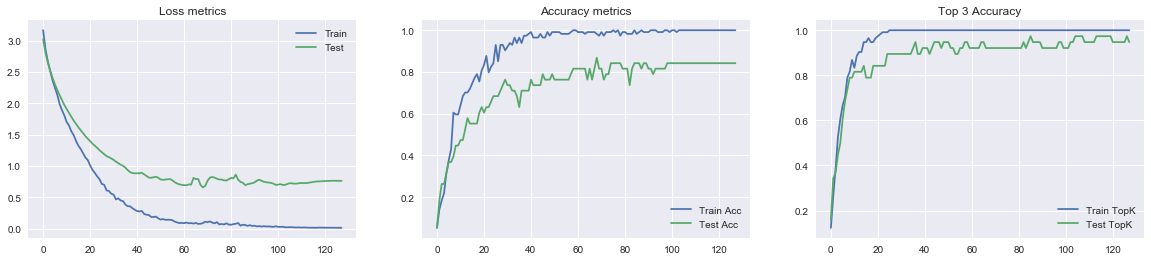

In [15]:
# plot history
plt.figure(figsize=[20,4])
plt.subplot(131)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title("Loss metrics")
plt.legend()
plt.subplot(132)
plt.plot(history.history['acc'], label='Train Acc')
plt.plot(history.history['val_acc'], label='Test Acc')
plt.title("Accuracy metrics")
plt.legend()
plt.subplot(133)
plt.plot(history.history['top3_acc'][:150], label='Train TopK')
plt.plot(history.history['val_top3_acc'][:150], label='Test TopK')
plt.title("Top 3 Accuracy")
plt.legend()
plt.show()

In [17]:
scores = model.evaluate(htrain_x, htrain_y, verbose=1)
print('Training Loss:', scores[0])
print('Training Accuracy:', scores[1]*100,'%')
print('Training Top 3 Accuracy:', scores[2]*100,'%')
scores = model.evaluate(htest_x, htest_y, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1]*100,'%')
print('Training Top 3 Accuracy:', scores[2]*100,'%')

114/114 [==============================] - 1s     
Training Loss: 0.0058015209639
Training Accuracy: 100.0 %
Training Top 3 Accuracy: 100.0 %
38/38 [==============================] - 0s     
Test loss: 0.764951594566
Test accuracy: 84.2105263158 %
Training Top 3 Accuracy: 94.7368421053 %


#### confusion matrix for the final model

38/38 [==============================] - 0s     


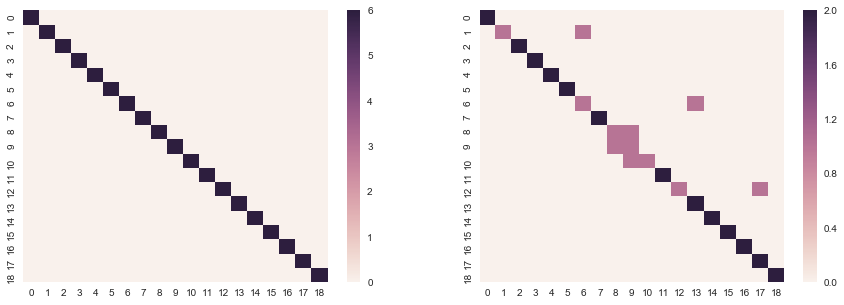

In [50]:
plt.figure(figsize=[15,5])
plt.subplot(121)
sn.heatmap(metrics.confusion_matrix(htrain_y, model.predict_classes(htrain_x)))

plt.subplot(122)
sn.heatmap(metrics.confusion_matrix(htest_y, model.predict_classes(htest_x)))

### 1-Dimensional Convolutional Neural Network
Another interesting model for pattern detection is the convolution neural network, while usually used for image classification, convolutional neural networks are proven to work well with sequence data.<br>
we achieved the following metrics from the model:
<br><br>Training Loss: 0.00405181182029
<br>Training Accuracy: 100.0 %
<br>Training Top 3 Accuracy: 100.0 %
<br>Test loss: 1.59485659474
<br>Test accuracy: 73.6842102126 %
<br>Training Top 3 Accuracy: 89.4736842105 %
<br><br>While the accuracy metrics of the CNN was not as good as the best case lstm/gru models, the training time was record breaking fast at under a minute.

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

modelc = Sequential()
modelc.add(Conv1D(64, 3, activation='relu', input_shape=[htrain_x.shape[1], htrain_x.shape[2]]))
modelc.add(Conv1D(64, 3, activation='relu'))
modelc.add(MaxPooling1D(3))
modelc.add(Conv1D(128, 3, activation='relu'))
modelc.add(Conv1D(128, 3, activation='relu'))
modelc.add(GlobalAveragePooling1D())    
modelc.add(Dense(512))
modelc.add(Activation('relu'))
modelc.add(Dropout(0.5))
modelc.add(Dense(19, activation='softmax'))

modelc.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',top3_acc])

history_c = modelc.fit(htrain_x, htrain_y, batch_size=64, epochs=128,validation_data=(htest_x, htest_y), verbose=2, shuffle=True)

Train on 114 samples, validate on 38 samples
Epoch 1/128
1s - loss: 3.9247 - acc: 0.0702 - top3_acc: 0.1842 - val_loss: 2.7257 - val_acc: 0.0526 - val_top3_acc: 0.2368
Epoch 2/128
0s - loss: 3.0039 - acc: 0.0877 - top3_acc: 0.2368 - val_loss: 2.6895 - val_acc: 0.0526 - val_top3_acc: 0.2632
Epoch 3/128
0s - loss: 2.7243 - acc: 0.1228 - top3_acc: 0.2719 - val_loss: 2.6444 - val_acc: 0.1842 - val_top3_acc: 0.4211
Epoch 4/128
0s - loss: 2.5941 - acc: 0.2018 - top3_acc: 0.4211 - val_loss: 2.6068 - val_acc: 0.1842 - val_top3_acc: 0.4211
Epoch 5/128
0s - loss: 2.5323 - acc: 0.2456 - top3_acc: 0.4561 - val_loss: 2.5225 - val_acc: 0.2105 - val_top3_acc: 0.4737
Epoch 6/128
0s - loss: 2.4415 - acc: 0.3246 - top3_acc: 0.4561 - val_loss: 2.4485 - val_acc: 0.2895 - val_top3_acc: 0.4474
Epoch 7/128
0s - loss: 2.3152 - acc: 0.3333 - top3_acc: 0.5526 - val_loss: 2.3508 - val_acc: 0.3684 - val_top3_acc: 0.5526
Epoch 8/128
0s - loss: 2.1464 - acc: 0.3684 - top3_acc: 0.6228 - val_loss: 2.1999 - val_acc: 0

0s - loss: 0.0816 - acc: 0.9825 - top3_acc: 1.0000 - val_loss: 1.3242 - val_acc: 0.7368 - val_top3_acc: 0.9211
Epoch 68/128
0s - loss: 0.0584 - acc: 0.9825 - top3_acc: 1.0000 - val_loss: 1.5029 - val_acc: 0.7105 - val_top3_acc: 0.8947
Epoch 69/128
0s - loss: 0.0770 - acc: 0.9825 - top3_acc: 1.0000 - val_loss: 1.3612 - val_acc: 0.7368 - val_top3_acc: 0.9211
Epoch 70/128
0s - loss: 0.0714 - acc: 0.9649 - top3_acc: 1.0000 - val_loss: 1.3695 - val_acc: 0.7368 - val_top3_acc: 0.9211
Epoch 71/128
0s - loss: 0.0892 - acc: 0.9737 - top3_acc: 1.0000 - val_loss: 1.7316 - val_acc: 0.6842 - val_top3_acc: 0.9211
Epoch 72/128
0s - loss: 0.0941 - acc: 0.9649 - top3_acc: 1.0000 - val_loss: 1.4488 - val_acc: 0.7895 - val_top3_acc: 0.9211
Epoch 73/128
0s - loss: 0.0753 - acc: 0.9649 - top3_acc: 1.0000 - val_loss: 1.4649 - val_acc: 0.6842 - val_top3_acc: 0.9211
Epoch 74/128
0s - loss: 0.0489 - acc: 0.9825 - top3_acc: 1.0000 - val_loss: 1.4596 - val_acc: 0.7368 - val_top3_acc: 0.9211
Epoch 75/128
0s - los

In [59]:
scores = modelc.evaluate(htrain_x, htrain_y, verbose=1)
print('Training Loss:', scores[0])
print('Training Accuracy:', scores[1]*100,'%')
print('Training Top 3 Accuracy:', scores[2]*100,'%')
scores = modelc.evaluate(htest_x, htest_y, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1]*100,'%')
print('Training Top 3 Accuracy:', scores[2]*100,'%')

 96/114 [========================>.....] - ETA: 0sTraining Loss: 0.00405181182029
Training Accuracy: 100.0 %
Training Top 3 Accuracy: 100.0 %
32/38 [========================>.....] - ETA: 0sTest loss: 1.59485659474
Test accuracy: 73.6842102126 %
Training Top 3 Accuracy: 89.4736842105 %


## Conclusion
We investigate inter-activity variability based on a publicly available activity dataset available at uci machine learning repository, and provided some definitions that quantify such variability. We considered pre-processing the acquired time sequences and feature vectors in different ways and generated 3 pairs of training and test feature vectors. We used one subject of each sex in the test set to reduce bias error.<br>
We observed the similarities between various activity and classified activities readings into static, periodic and random fluctuations. We also defined a fair boundary between the acitivities that allowed us to classify the activities based on their sensor readings.<br>
This experiment tells us how powerful wearable sensors can be in predicting the activities performed by the person, which can have countless use cases in the new era of wearable smart technology.<br>
We did notice some activities have trouble being classified correctly, especially when they have close neighbors. however it should be tackleable by increasing the complexity of the feature extraction, since we only used common operations(even though they proved to be extremely useful too).
<br>The experiment covered an extremly wide spectrum of activities which proves that these models can be applied in all sorts of sensor datasets, an interesting to ponder can be a classifier which can predict the type of dance using the sensor readings from the dancer.
<br><br>
This experiment had a completion time frame involved so there is still a of space for improvement in it. Some things to implement in the future include splitting the training and test sets based on the time series instead of subjects, using more complex features for the training sets using methods such as pca, dft and correlations, and experiment with deeper neural networks.

### References
* K. Altun, B. Barshan, and O. Tun√ßel,<br>
"Comparative study on classifying human activities with miniature inertial and magnetic sensors,"<br>
Pattern Recognition, 43(10):3605-3620, October 2010.
* Billur Barshan and Aras Yurtm,<br>
"Investigating Inter-Subject and Inter-Activity Variations in Activity Recognition Using Wearable Motion Sensors"<br>
Department of Electrical and Electronics Engineering, Bilkent University, Bilkent, TR-06800 Ankara, Turkey
